In [1]:
# Importing libraries

import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.cluster import KMeans

### Importing data from CSV file

In [2]:
# Referencing data file relative to the current directory
# Adjust read directory below as needed

Data = pd.read_csv('../../data/OriginalData.csv')

### Cast Dates columns

In [3]:
# In order to prepare date columns for use in models, we need to cast them to the proper data type.

# Changing the dates from string to datetime64 data type for all relevant columns
# Columns: "Dates", "DATE_OF_LAST_BOD_CHANGE", "DATE_OF_LAST_EXECUTIVE_CHANGE"

Data["Dates"] = pd.to_datetime(Data["Dates"])
Data["DATE_OF_LAST_BOD_CHANGE"] = pd.to_datetime(Data["DATE_OF_LAST_BOD_CHANGE"])
Data["DATE_OF_LAST_EXECUTIVE_CHANGE"] = pd.to_datetime(Data["DATE_OF_LAST_EXECUTIVE_CHANGE"])

### (Obsolete) Restructure data to include ticker in every feature

In [4]:
# Restructure dataset to attach tickers to each feature producing a wide data set

dates = Data['Dates'].unique()

new_df = pd.DataFrame()
new_df["Dates"] = dates

# Iterate over each unique symbol and its associated group in the Data DataFrame
for symbol, group in Data.groupby('symbol'):

    # Remove the 'symbol' column from the group and prefix remaining columns with the symbol name
    group = group.drop(columns=['symbol']).add_prefix(f"{symbol}_")

    # Merge the modified group DataFrame with new_df on the 'Dates' column, matching with prefixed symbol dates
    new_df = pd.merge(new_df, group, left_on="Dates", right_on=f"{symbol}_Dates", how="left")

    # Drop the redundant 'Dates' column after merging, as it's now represented with the symbol prefix
    new_df.drop(f"{symbol}_Dates", axis=1, inplace=True)

In [5]:
# Display data

display(new_df)

,Dates,AAPL_PX_LAST,AAPL_Dividend_Per_Share,AAPL_TOTAL_EQUITY,AAPL_CUR_MKT_CAP,AAPL_gics_sector_name,AAPL_gics_sub_industry_name,AAPL_gics_industry_name,AAPL_gics_industry_group_name,AAPL_gics_industry,...,XOM_NUM_CEOS_EQUIV_INC_COMP_PD,XOM_CEO_TENURE_AS_OF_FY_END,XOM_TOT_COMP_AW_TO_CFO_EQUIV,XOM_TOT_COMP_AW_TO_COO_EQUIV,XOM_TOTAL_BOD_COMPENSATION_AWARDED,XOM_TOTAL_BOD_FEES_PAID_IN_CASH,XOM_TOTAL_BOD_STOCK_AWARDS_GIVEN,XOM_NUMBER_OF_BOD_CHANGES_DURING_FY,XOM_DATE_OF_LAST_BOD_CHANGE,XOM_NUM_DIR_INC_IN_CMPNSTN_PD
0,2014-04-11,18.558,0.1089,120179.0,4.634864e+05,Information Technology,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals",Technology Hardware & Equipment,452020,...,1,9.0,0.0,0,4290988.0,1285029.0,3002100.0,1,2014-05-23,12
1,2014-04-18,18.748,0.1089,120179.0,4.682407e+05,Information Technology,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals",Technology Hardware & Equipment,452020,...,1,9.0,0.0,0,4290988.0,1285029.0,3002100.0,1,2014-05-23,12
2,2014-04-25,20.426,0.1089,120179.0,4.926582e+05,Information Technology,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals",Technology Hardware & Equipment,452020,...,1,9.0,0.0,0,4290988.0,1285029.0,3002100.0,1,2014-05-23,12
3,2014-05-02,21.164,0.1089,120179.0,5.104371e+05,Information Technology,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals",Technology Hardware & Equipment,452020,...,1,9.0,0.0,0,4290988.0,1285029.0,3002100.0,1,2014-05-23,12
4,2014-05-09,20.912,0.1089,120179.0,5.043752e+05,Information Technology,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals",Technology Hardware & Equipment,452020,...,1,9.0,0.0,0,4290988.0,1285029.0,3002100.0,1,2014-05-23,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,2023-12-01,191.240,0.2400,62146.0,2.974308e+06,Information Technology,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals",Technology Hardware & Equipment,452020,...,1,7.0,18047556.0,0,5746801.0,1325934.0,4418160.0,3,2023-05-30,12
504,2023-12-08,195.710,0.2400,62146.0,3.043829e+06,Information Technology,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals",Technology Hardware & Equipment,452020,...,1,7.0,18047556.0,0,5746801.0,1325934.0,4418160.0,3,2023-05-30,12
505,2023-12-15,197.570,0.2400,62146.0,3.072757e+06,Information Technology,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals",Technology Hardware & Equipment,452020,...,1,7.0,18047556.0,0,5746801.0,1325934.0,4418160.0,3,2023-05-30,12
506,2023-12-22,193.600,0.2400,62146.0,3.011013e+06,Information Technology,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals",Technology Hardware & Equipment,452020,...,1,7.0,18047556.0,0,5746801.0,1325934.0,4418160.0,3,2023-05-30,12


In [6]:
# Display dimensions of originally imported data and reshaped data respectively
# Ensure that second set of dimensions corresponds to a wide matrix

print("{} {}".format(new_df.shape,Data.shape))

(508, 1458) (15748, 49)


### Display all symbols in imported data set

In [7]:
Data['symbol'].unique()

array(['AAPL', 'AMT', 'AMZN', 'BHP', 'CAT', 'COST', 'CVX', 'DUK', 'EQIX',
       'GE', 'HD', 'JPM', 'LLY', 'META', 'MSFT', 'NEE', 'NFLX', 'NVDA',
       'NVO', 'PG', 'PLD', 'RTX', 'SHEL', 'SHW', 'SO', 'TSLA', 'UNH', 'V',
       'WFC', 'WMT', 'XOM'], dtype=object)

### (Example) Display Last Price on frequency table

<Axes: >

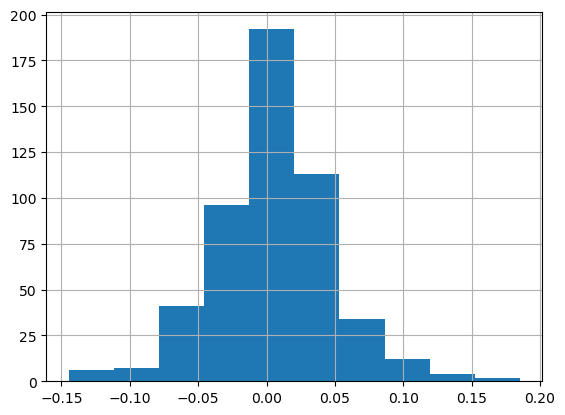

In [8]:
# Change the ticker in the variable name in order to view different stocks
# i.e. MSFT_PX_LAST, AAPL_PX_LAST

new_df["AMZN_PX_LAST"].pct_change(periods=1).hist()

### Scale data using StandardScaler()

In [9]:
# Apply Z-Score scaling to data set
# ONLY scale numerical data represented by float or int data types (i.e. NO datetimes, categorical, etc.)
# entry = (entry - mean) / standard dev.

# Separate numeric data
df_numeric = new_df.select_dtypes(include=[float, int])

# Define StandardScaler object
scaler = StandardScaler()

# Fit and transform data
scaled_data = scaler.fit_transform(df_numeric)

# Define scaled data as Pandas dataframe
df_scaled = pd.DataFrame(scaled_data, columns=df_numeric.columns)

# Recombine scaled data dataframe with previously separated data
df_non_numeric = new_df.select_dtypes(exclude=[float, int])
df_final = pd.concat([df_scaled, df_non_numeric], axis=1)

In [10]:
# Display data to ensure correctness

df_final.head()

,AAPL_PX_LAST,AAPL_Dividend_Per_Share,AAPL_TOTAL_EQUITY,AAPL_CUR_MKT_CAP,AAPL_gics_industry,AAPL_gics_sector,AAPL_Year,AAPL_TOT_COMPENSATION_AW_TO_EXECS,AAPL_TOT_SALARIES_BNS_PD_TO_EXECS,AAPL_TOT_N_EQTY_INCENT_GIVEN_TO_EXECS,...,WMT_gics_industry_name,WMT_gics_industry_group_name,WMT_DATE_OF_LAST_EXECUTIVE_CHANGE,WMT_DATE_OF_LAST_BOD_CHANGE,XOM_gics_sector_name,XOM_gics_sub_industry_name,XOM_gics_industry_name,XOM_gics_industry_group_name,XOM_DATE_OF_LAST_EXECUTIVE_CHANGE,XOM_DATE_OF_LAST_BOD_CHANGE
0,-1.085666,-1.682868,0.730651,-1.118006,0.0,0.0,-1.645564,0.677288,-0.140378,-0.108532,...,Consumer Staples Distribution & Retail,Consumer Staples Distribution & Retail,2014-01-31,2013-12-31,Energy,Integrated Oil & Gas,"Oil, Gas & Consumable Fuels",Energy,2013-01-01,2014-05-23
1,-1.082283,-1.682868,0.730651,-1.112273,0.0,0.0,-1.645564,0.677288,-0.140378,-0.108532,...,Consumer Staples Distribution & Retail,Consumer Staples Distribution & Retail,2014-01-31,2013-12-31,Energy,Integrated Oil & Gas,"Oil, Gas & Consumable Fuels",Energy,2013-01-01,2014-05-23
2,-1.052406,-1.682868,0.730651,-1.082829,0.0,0.0,-1.645564,0.677288,-0.140378,-0.108532,...,Consumer Staples Distribution & Retail,Consumer Staples Distribution & Retail,2014-01-31,2013-12-31,Energy,Integrated Oil & Gas,"Oil, Gas & Consumable Fuels",Energy,2013-01-01,2014-05-23
3,-1.039265,-1.682868,0.730651,-1.061390,0.0,0.0,-1.645564,0.677288,-0.140378,-0.108532,...,Consumer Staples Distribution & Retail,Consumer Staples Distribution & Retail,2014-01-31,2013-12-31,Energy,Integrated Oil & Gas,"Oil, Gas & Consumable Fuels",Energy,2013-01-01,2014-05-23
4,-1.043752,-1.682868,0.730651,-1.068700,0.0,0.0,-1.645564,0.677288,-0.140378,-0.108532,...,Consumer Staples Distribution & Retail,Consumer Staples Distribution & Retail,2014-01-31,2013-12-31,Energy,Integrated Oil & Gas,"Oil, Gas & Consumable Fuels",Energy,2013-01-01,2014-05-23


### (Example) Distribution of AAPL_PX_LAST

1.6784474073073233e-16
0.9999999999999999


<Axes: xlabel='AAPL_PX_LAST', ylabel='Count'>

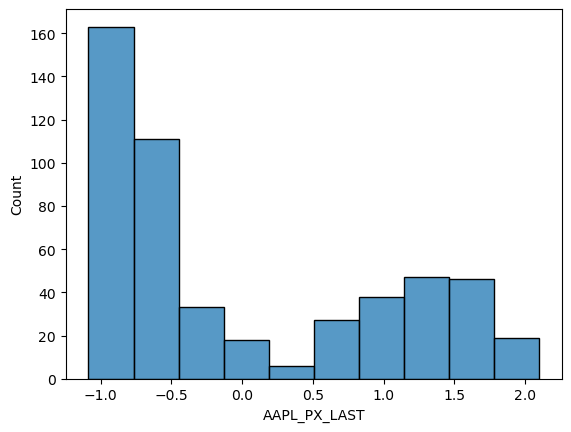

In [11]:
# Calculating number statistics for AAPL_PX_LAST and Z-Scaling it
# Change ticker within variable to view other distributions

mu = np.mean(df_final["AAPL_PX_LAST"])
sigma = np.std(df_final["AAPL_PX_LAST"])
scaled_df = (new_df['AAPL_PX_LAST'] - mu )/ sigma

print(mu)
print(sigma)

sns.histplot(df_final['AAPL_PX_LAST'])

<Axes: xlabel='AAPL_TOT_N_EQTY_INCENT_GIVEN_TO_EXECS', ylabel='Count'>

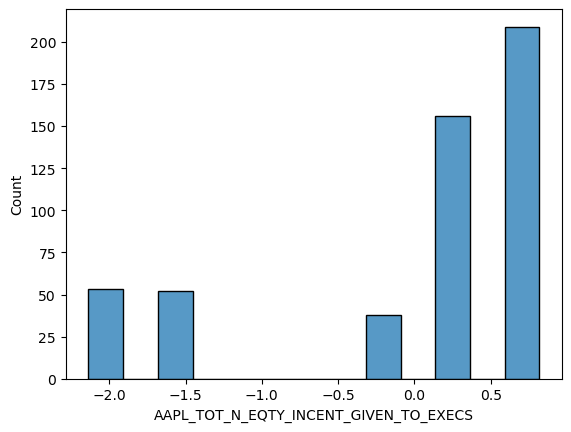

In [12]:
# Sample output
# Plotting a histogram of the 'AAPL_TOT_N_EQTY_INCENT_GIVEN_TO_EXECS' column from the df_final DataFrame

sns.histplot(df_final["AAPL_TOT_N_EQTY_INCENT_GIVEN_TO_EXECS"])

### One hot encode categorical data

In [13]:
# Exclude dates for OHE
df_non_dates =df_final.select_dtypes(exclude=['datetime'])

In [14]:
# Converting categorical variables in df_non_dates to one-hot encoded columns and save to a CSV file

# Perform one-hot encoding on the df_non_dates DataFrame
data_ohe = pd.get_dummies(df_non_dates)

# Display the one-hot encoded DataFrame
display(pd.get_dummies(df_non_dates))  

# Save the one-hot encoded DataFrame to a CSV file
# Change save directory as necessary
data_ohe.to_csv('../../out/data_ohe.csv')  

,AAPL_PX_LAST,AAPL_Dividend_Per_Share,AAPL_TOTAL_EQUITY,AAPL_CUR_MKT_CAP,AAPL_gics_industry,AAPL_gics_sector,AAPL_Year,AAPL_TOT_COMPENSATION_AW_TO_EXECS,AAPL_TOT_SALARIES_BNS_PD_TO_EXECS,AAPL_TOT_N_EQTY_INCENT_GIVEN_TO_EXECS,...,WFC_gics_industry_name_Banks,WFC_gics_industry_group_name_Banks,WMT_gics_sector_name_Consumer Staples,WMT_gics_sub_industry_name_Consumer Staples Merchandise Retail,WMT_gics_industry_name_Consumer Staples Distribution & Retail,WMT_gics_industry_group_name_Consumer Staples Distribution & Retail,XOM_gics_sector_name_Energy,XOM_gics_sub_industry_name_Integrated Oil & Gas,"XOM_gics_industry_name_Oil, Gas & Consumable Fuels",XOM_gics_industry_group_name_Energy
0,-1.085666,-1.682868,0.730651,-1.118006,0.0,0.0,-1.645564,0.677288,-0.140378,-0.108532,...,True,True,True,True,True,True,True,True,True,True
1,-1.082283,-1.682868,0.730651,-1.112273,0.0,0.0,-1.645564,0.677288,-0.140378,-0.108532,...,True,True,True,True,True,True,True,True,True,True
2,-1.052406,-1.682868,0.730651,-1.082829,0.0,0.0,-1.645564,0.677288,-0.140378,-0.108532,...,True,True,True,True,True,True,True,True,True,True
3,-1.039265,-1.682868,0.730651,-1.061390,0.0,0.0,-1.645564,0.677288,-0.140378,-0.108532,...,True,True,True,True,True,True,True,True,True,True
4,-1.043752,-1.682868,0.730651,-1.068700,0.0,0.0,-1.645564,0.677288,-0.140378,-0.108532,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,1.988983,1.541515,-1.239244,1.909706,0.0,0.0,1.557296,0.576384,0.118244,0.170422,...,True,True,True,True,True,True,True,True,True,True
504,2.068572,1.541515,-1.239244,1.993539,0.0,0.0,1.557296,0.576384,0.118244,0.170422,...,True,True,True,True,True,True,True,True,True,True
505,2.101690,1.541515,-1.239244,2.028422,0.0,0.0,1.557296,0.576384,0.118244,0.170422,...,True,True,True,True,True,True,True,True,True,True
506,2.031003,1.541515,-1.239244,1.953967,0.0,0.0,1.557296,0.576384,0.118244,0.170422,...,True,True,True,True,True,True,True,True,True,True


### Apply prinicple component analysis

In [22]:
# Define number of components to end with after applying PCA
num_components = 30

# Define PCA object; fit and transform one hot encoded data
pca=PCA(n_components=num_components)
pca.fit(data_ohe)
Data_pca=pca.transform(data_ohe)

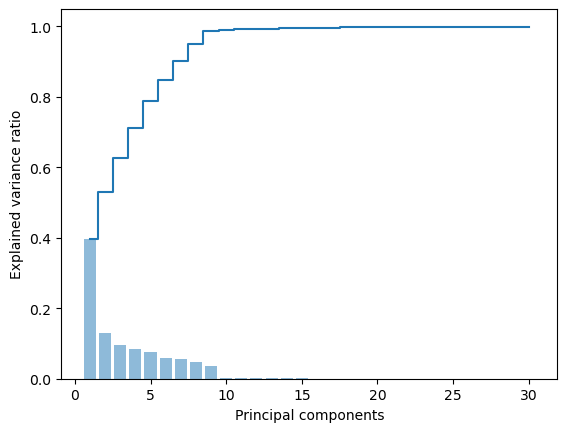

In [24]:
# Plot number of principle components to explained variance ratio 
# Adjust number of components in cell above to test different ratios

plt.bar(range(1, num_components+1), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, num_components+1), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

### PCA into DataFrame

In [25]:
# Convert the PCA-transformed data (Data_pca) into a DataFrame and display it

# Create a DataFrame from the PCA-transformed data
Data_pca_df = pd.DataFrame(Data_pca) 

# Display the resulting DataFrame
display(Data_pca_df) 

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-30.403997,14.067443,-19.045417,-3.445448,12.929580,-2.918942,8.514475,7.099839,-4.079050,-0.543496,...,-0.098667,-0.093674,0.104831,0.018464,0.520125,0.402473,-0.137698,0.043440,0.053828,-0.502802
1,-30.347489,14.140789,-19.019729,-3.410329,12.981323,-2.979745,8.583659,7.100836,-4.060926,-0.440225,...,-0.051276,-0.175464,0.082932,-0.173245,0.475113,0.367737,-0.094228,-0.001834,0.127455,-0.433434
2,-30.331115,14.146297,-19.021889,-3.404104,12.971592,-2.983661,8.584910,7.106793,-4.059217,-0.406221,...,-0.004967,-0.168105,-0.008897,-0.159805,0.408570,0.311970,-0.156778,-0.023678,0.150556,-0.426292
3,-30.343408,14.119006,-18.966041,-3.417368,13.031858,-3.017905,8.636669,7.099863,-4.073780,-0.504183,...,-0.296057,-0.479532,0.207360,-0.049037,0.264093,0.169427,-0.254051,-0.020956,0.359036,-0.169762
4,-30.352272,14.114160,-18.963115,-3.430211,13.033849,-3.028308,8.633226,7.099871,-4.076103,-0.571764,...,-0.275885,-0.464402,0.272194,-0.050164,0.248525,0.206811,-0.187830,-0.001481,0.362531,-0.150930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,32.286208,17.954130,12.657197,-10.222674,6.997502,4.834975,2.532058,-0.570412,-2.693304,2.648328,...,-0.682772,0.284242,-0.217334,-0.587157,0.555271,0.058934,-0.646064,-0.012842,-0.247965,0.012109
504,32.295281,17.927382,12.650383,-10.192580,6.977593,4.863143,2.506076,-0.574488,-2.689142,2.754780,...,-0.684405,0.270342,-0.292872,-0.464692,0.715944,-0.179323,-0.746350,-0.106603,-0.334994,-0.017245
505,32.509915,17.971302,12.603535,-10.087797,7.038210,4.884300,2.551729,-0.576545,-2.663821,3.413945,...,-0.567806,0.463377,-0.528751,-0.151567,0.584782,-0.466169,-1.210122,-0.000604,-0.616132,0.086295
506,32.590035,18.004049,12.591141,-10.082058,7.094131,4.901715,2.589667,-0.581579,-2.668139,3.637254,...,-0.621810,0.405474,-0.562091,-0.206636,0.519597,-0.255136,-1.177465,0.122844,-0.573470,0.016321


,0
0,522114.171927
1,354528.075853
2,278079.846584
3,232613.910993
4,173164.295770
5,129103.244721
6,92072.442270
7,60224.141761
8,30015.889031
9,5213.717248


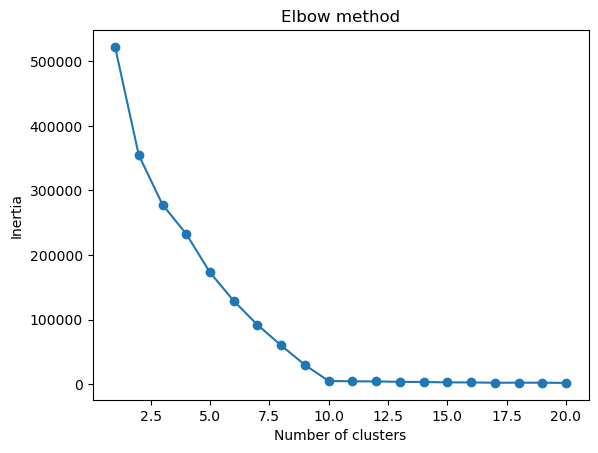

In [26]:
# Applying K-means
# Elbow method (first 10 PCA)
# We can also take into account the silhouette score

inertias = []
for i in range(1,21):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(Data_pca[:,0:20])
    inertias.append(kmeans.inertia_)

plt.plot(range(1,21), inertias, marker='o')

display(pd.DataFrame(inertias))

plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
# Perform K-means clustering with 5 clusters on the PCA-transformed data
kmeans = KMeans(n_clusters=5)  # Initialize K-means with 5 clusters
kmeans.fit(Data_pca)  # Fit the K-means model to the PCA-transformed data
labels = kmeans.labels_  # Get the cluster labels assigned to each data point

<Axes: >

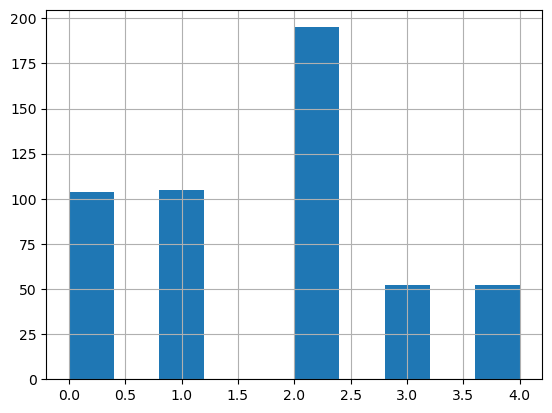

In [ ]:
#Visualizing distribution for n_clusters = 5

pd.DataFrame(labels)[0].hist()

### Decision tree

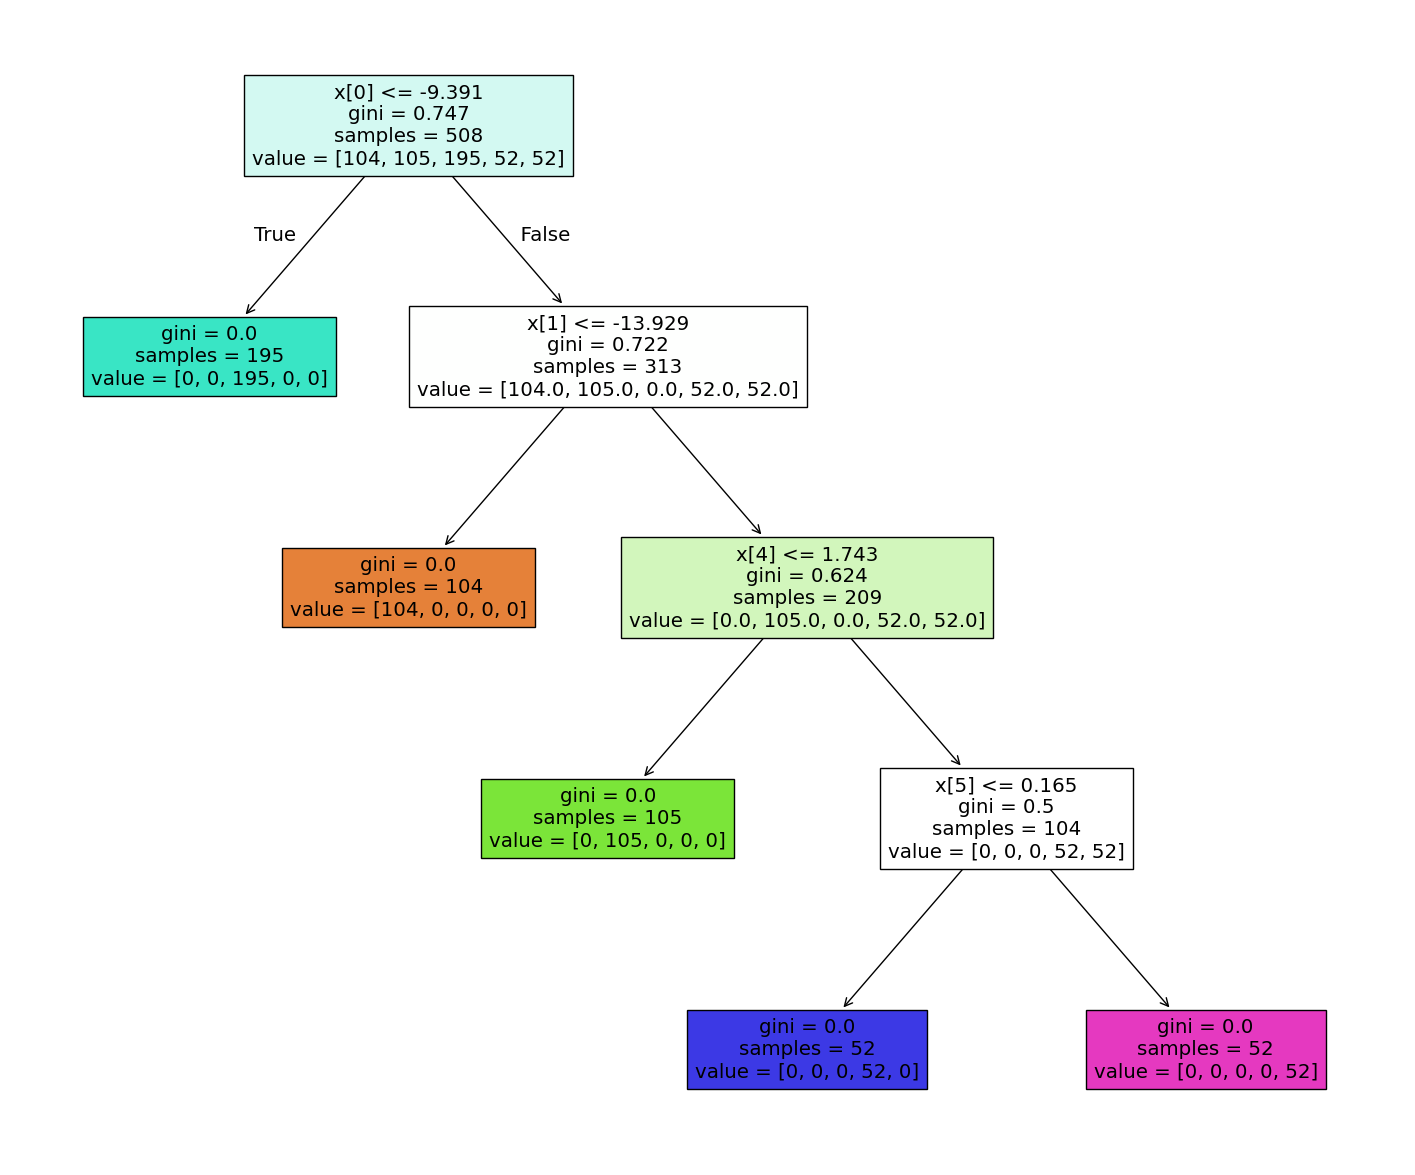

In [ ]:
# We can also consider other ML models such as random forest

clf = DecisionTreeClassifier(random_state=1)

# Training the classifier (we can consider test train split)

clf.fit(Data_pca, labels)

plt.figure(figsize=(18, 15))
plot_tree(clf, filled=True)
plt.show()

In [ ]:
# Save the Data DataFrame to a CSV file in the specified Google Drive path
# Data.to_csv("/content/drive/My Drive/GQG/OriginalData_2.csv")

OSError: Cannot save file into a non-existent directory: '/content/drive/My Drive/GQG'